In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score

# Load the car dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
url_local = "car_evaluation.csv"
column_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
data_frame = pd.read_csv(url, names=column_names)

# Preprocess the data: Convert categorical variables to numerical
for column in data_frame.columns:
    data_frame[column] = data_frame[column].astype('category').cat.codes

# Define function to evaluate model
def evaluate_classifier(X_train, X_test, y_train, y_test, criterion):
    # Initialize and train Decision Tree Classifier
    clf = DecisionTreeClassifier(criterion=criterion)
    clf.fit(X_train, y_train)

    # Predict on test set
    y_pred = clf.predict(X_test)

    # Calculate confusion matrix and F1-score
    conf_matrix = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    return conf_matrix, f1

# Define function to perform experiment
def perform_experiment(train_size, num_repeats, criterion):
    accuracies = []
    for _ in range(num_repeats):
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(data_frame.iloc[:, :-1], data_frame['class'], train_size=train_size)

        # Evaluate model
        conf_matrix, f1 = evaluate_classifier(X_train, X_test, y_train, y_test, criterion)
        accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
        accuracies.append(accuracy)

    avg_accuracy = np.mean(accuracies)
    return avg_accuracy

# Define function to perform experiments for different parameters
def perform_experiments(train_sizes, num_repeats, criteria):
    results = {}
    for train_size in train_sizes:
        results[train_size] = {}
        for criterion in criteria:
            avg_accuracy = perform_experiment(train_size, num_repeats, criterion)
            results[train_size][criterion] = avg_accuracy
    return results

# Parameters
train_sizes = [0.6, 0.7, 0.8]
num_repeats = 20
criteria = ['entropy', 'gini']

# Perform experiments
results = perform_experiments(train_sizes, num_repeats, criteria)

# Print results
for train_size in train_sizes:
    print(f"Train Size: {train_size * 100}%")
    for criterion in criteria:
        print(f"Criterion: {criterion.capitalize()} - Average Accuracy: {results[train_size][criterion]}")
    print()


Train Size: 60.0%
Criterion: Entropy - Average Accuracy: 0.9721820809248554
Criterion: Gini - Average Accuracy: 0.966257225433526

Train Size: 70.0%
Criterion: Entropy - Average Accuracy: 0.9757225433526011
Criterion: Gini - Average Accuracy: 0.9724470134874759

Train Size: 80.0%
Criterion: Entropy - Average Accuracy: 0.976300578034682
Criterion: Gini - Average Accuracy: 0.9789017341040462



In [ ]:
data_frame.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, f1_score
import graphviz
import os

# Load the car dataset
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
local_data_url = "car_evaluation.csv"
feature_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
data_frame = pd.read_csv(data_url, names=feature_names)

# Preprocess the data: Convert categorical variables to numerical
for column in data_frame.columns:
    data_frame[column] = data_frame[column].astype('category').cat.codes

# Define function to evaluate model
def evaluate_classifier(X_train, X_test, y_train, y_test, criterion):
    # Initialize and train Decision Tree Classifier
    clf = DecisionTreeClassifier(criterion=criterion)
    clf.fit(X_train, y_train)

    # Predict on test set
    y_pred = clf.predict(X_test)

    # Calculate confusion matrix and F1-score
    conf_matrix = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    return conf_matrix, f1, clf

# Define function to perform experiment
def perform_experiment(train_size, num_repeats, criterion):
    accuracies = []
    models = []
    for _ in range(num_repeats):
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(data_frame.iloc[:, :-1], data_frame['class'], train_size=train_size)

        # Evaluate model
        conf_matrix, f1, clf = evaluate_classifier(X_train, X_test, y_train, y_test, criterion)
        accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
        accuracies.append(accuracy)
        models.append(clf)

    avg_accuracy = np.mean(accuracies)
    return avg_accuracy, models

# Define function to perform experiments for different parameters
def perform_experiments(train_sizes, num_repeats, criteria):
    results = {}
    models = {}
    for train_size in train_sizes:
        results[train_size] = {}
        models[train_size] = {}
        for criterion in criteria:
            avg_accuracy, clf_models = perform_experiment(train_size, num_repeats, criterion)
            results[train_size][criterion] = avg_accuracy
            models[train_size][criterion] = clf_models
    return results, models

# Parameters
train_sizes = [0.6, 0.7, 0.8]
num_repeats = 20
criteria = ['entropy', 'gini']

# Perform experiments
results, models = perform_experiments(train_sizes, num_repeats, criteria)

# Visualize decision trees
for train_size in train_sizes:
    for criterion in criteria:
        print("Train Size: " + str(int(train_size * 100)) + "%, Criterion: " + criterion.capitalize())
        for i, clf in enumerate(models[train_size][criterion]):
            dot_data = export_graphviz(clf, out_file=None,
                                feature_names=data_frame.columns[:-1],
                                class_names=str(data_frame['class'].unique()),
                                filled=True, rounded=True,
                                special_characters=True)
            graph = graphviz.Source(dot_data)
            file_name = "decision_tree_" + str(int(train_size * 100)) + "_" + criterion + "_" + str(i) + ".pdf"
            graph.render(file_name)
            print("Decision Tree " + str(i+1) + ": Visualized and saved as " + file_name)


Train Size: 60%, Criterion: Entropy
Decision Tree 1: Visualized and saved as decision_tree_60_entropy_0.pdf
Decision Tree 2: Visualized and saved as decision_tree_60_entropy_1.pdf
Decision Tree 3: Visualized and saved as decision_tree_60_entropy_2.pdf
Decision Tree 4: Visualized and saved as decision_tree_60_entropy_3.pdf
Decision Tree 5: Visualized and saved as decision_tree_60_entropy_4.pdf
Decision Tree 6: Visualized and saved as decision_tree_60_entropy_5.pdf
Decision Tree 7: Visualized and saved as decision_tree_60_entropy_6.pdf
Decision Tree 8: Visualized and saved as decision_tree_60_entropy_7.pdf
Decision Tree 9: Visualized and saved as decision_tree_60_entropy_8.pdf
Decision Tree 10: Visualized and saved as decision_tree_60_entropy_9.pdf
Decision Tree 11: Visualized and saved as decision_tree_60_entropy_10.pdf
Decision Tree 12: Visualized and saved as decision_tree_60_entropy_11.pdf
Decision Tree 13: Visualized and saved as decision_tree_60_entropy_12.pdf
Decision Tree 14: Vis

Train Size: 60%, Criterion: Entropy


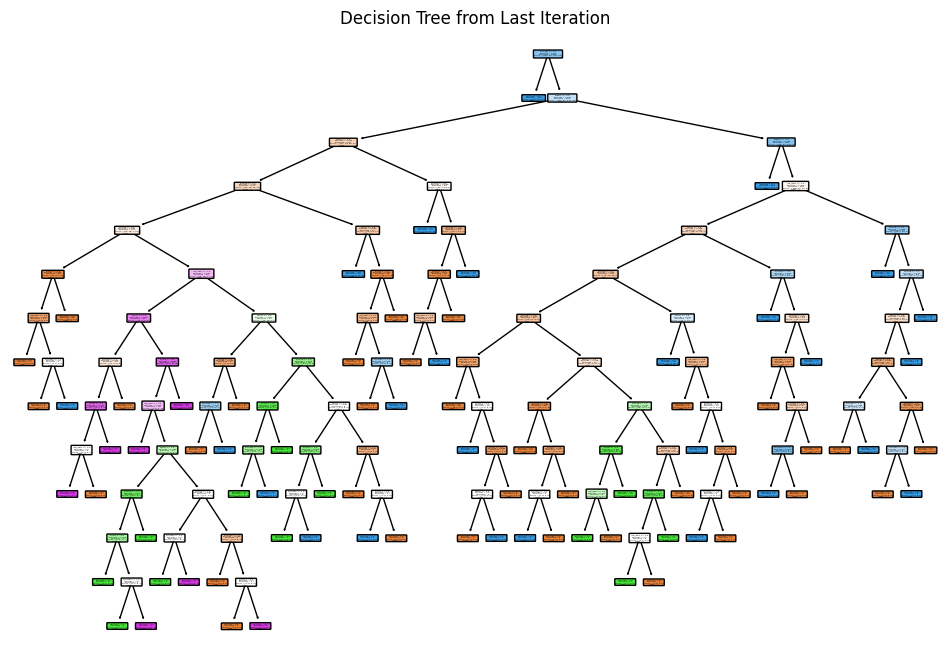

Train Size: 60%, Criterion: Gini


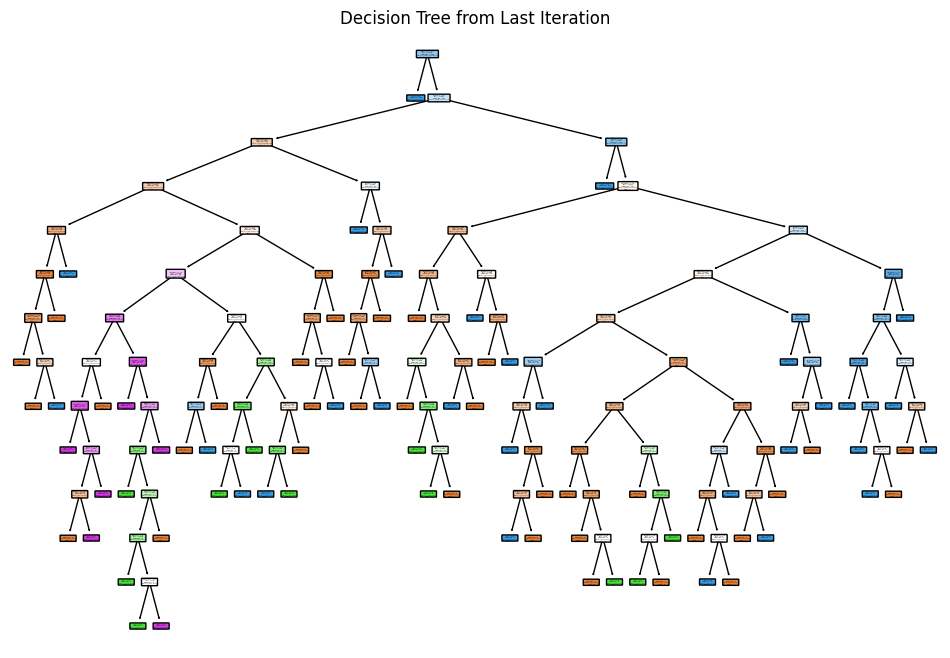

Train Size: 70%, Criterion: Entropy


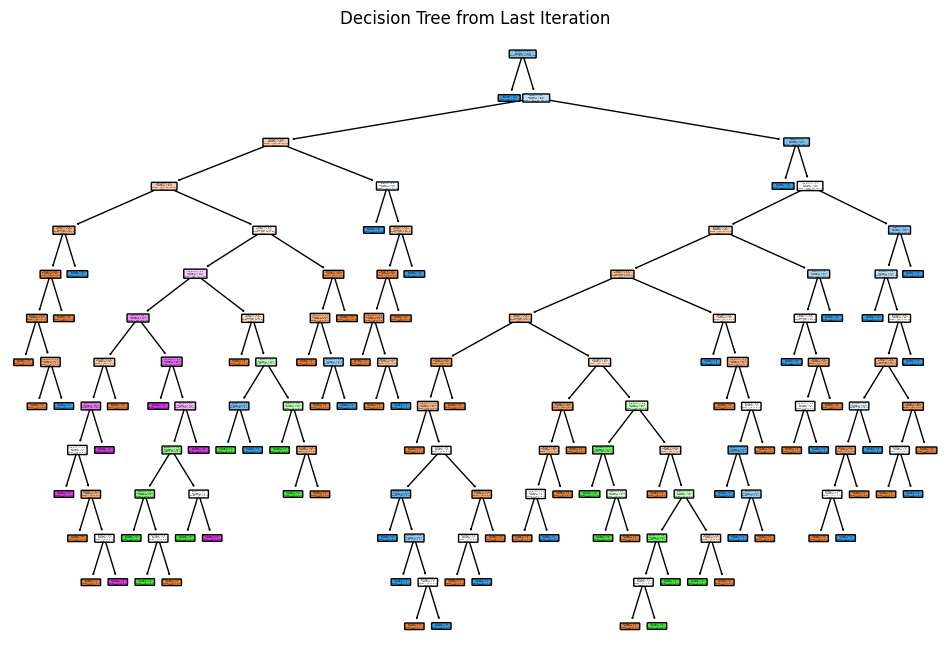

Train Size: 70%, Criterion: Gini


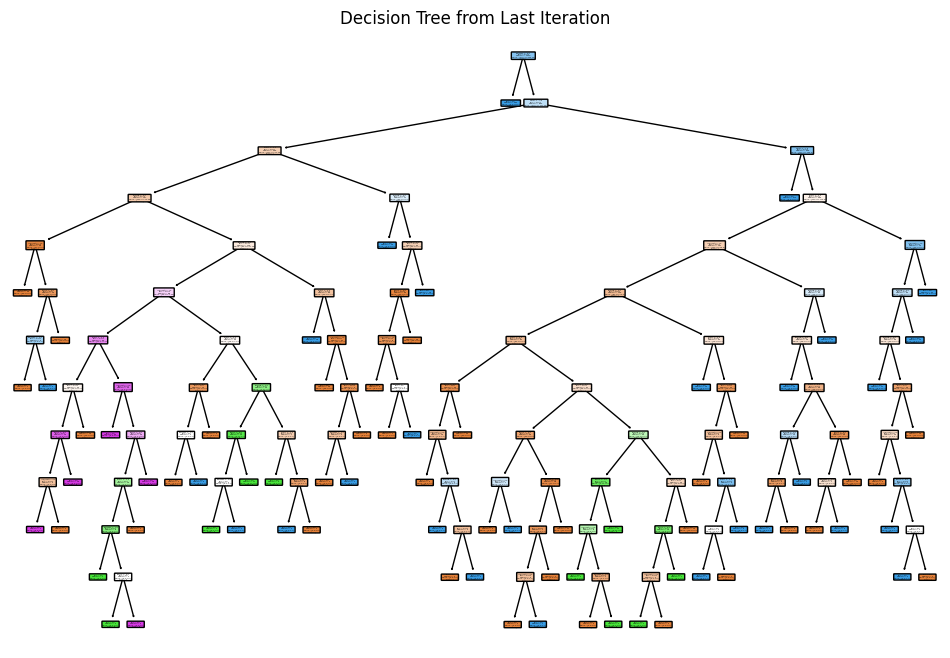

Train Size: 80%, Criterion: Entropy


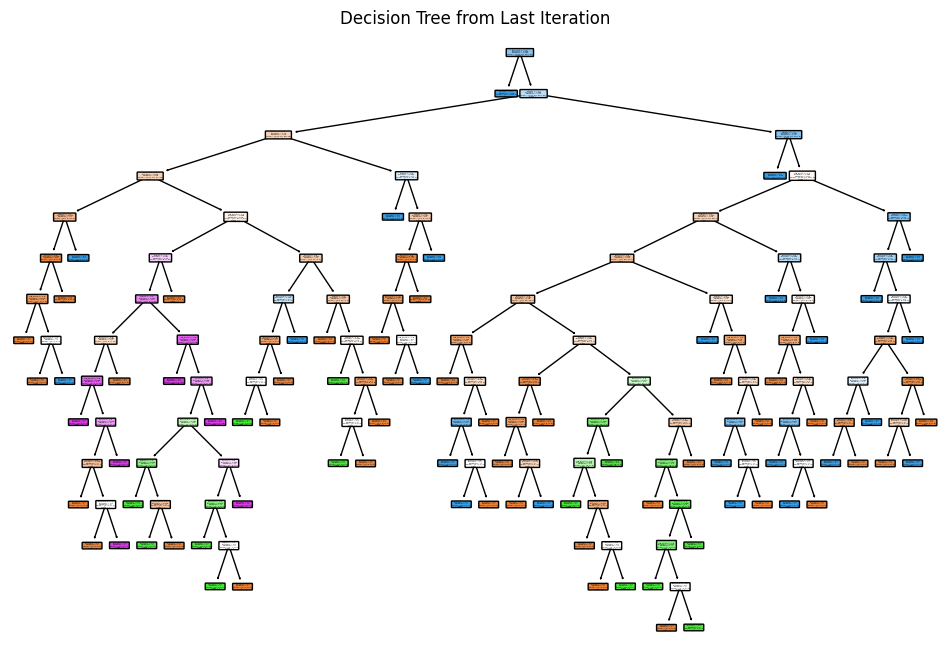

Train Size: 80%, Criterion: Gini


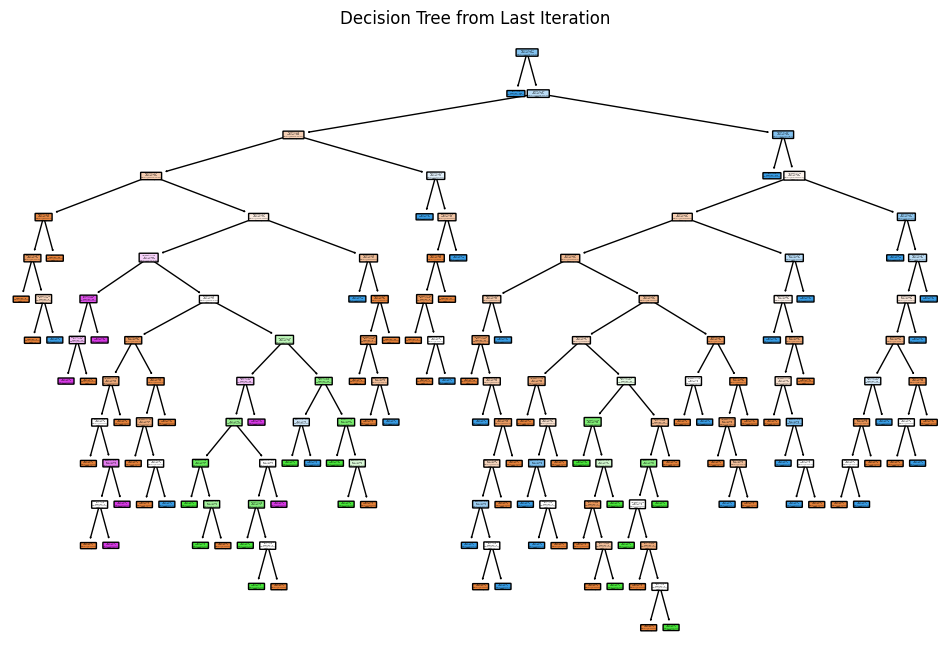

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Visualize decision trees for the last iteration only
last_iteration = num_repeats - 1
for train_size in train_sizes:
    for criterion in criteria:
        print("Train Size: " + str(int(train_size * 100)) + "%, Criterion: " + criterion.capitalize())
        clf = models[train_size][criterion][last_iteration]
        plt.figure(figsize=(12, 8))
        plot_tree(clf, feature_names=data_frame.columns[:-1], class_names=str(data_frame['class'].unique()), filled=True, rounded=True)
        plt.title("Decision Tree from Last Iteration")
        plt.show()


Overfitting Model:
Training Accuracy: 1.0
Testing Accuracy: 0.9380165289256198

Better Model:
Training Accuracy: 0.9362934362934363
Testing Accuracy: 0.903305785123967


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(data.iloc[:, :-1], data['class'], train_size=0.3)

# Train a decision tree with high max_depth (prone to overfitting)
overfitting_model_decision_tree = DecisionTreeClassifier(max_depth=15)
overfitting_model_decision_tree.fit(X_train_data, y_train_data)

# Train a decision tree with lower max_depth (less prone to overfitting)
better_model_decision_tree = DecisionTreeClassifier(max_depth=7)
better_model_decision_tree.fit(X_train_data, y_train_data)

# Evaluate performance on training and testing sets
overfitting_train_accuracy = accuracy_score(y_train_data, overfitting_model_decision_tree.predict(X_train_data))
overfitting_test_accuracy = accuracy_score(y_test_data, overfitting_model_decision_tree.predict(X_test_data))

better_train_accuracy = accuracy_score(y_train_data, better_model_decision_tree.predict(X_train_data))
better_test_accuracy = accuracy_score(y_test_data, better_model_decision_tree.predict(X_test_data))

# Print results
print("Overfitting Model:")
print("Training Accuracy:", overfitting_train_accuracy)
print("Testing Accuracy:", overfitting_test_accuracy)

print("\nBetter Model:")
print("Training Accuracy:", better_train_accuracy)
print("Testing Accuracy:", better_test_accuracy)
